# **Predicting the perception of deprivation from VHR Satelite Images.**

## Intro

This code is developed by [**Taïs Grippa**](https://github.com/tgrippa) for the **PARTIMAP** project, based on the initial code of [**Eqi Luo**](https://github.com/EqiLuo/MappingDeprivation). 



## 0. Import libraries

Firstly, install and import the necessary libraries for this analysis.

In [1]:
import numpy as np
import os
import pandas as pd
import glob
import re
from tensorflow import keras
import natsort
import sklearn
import tensorflow as tf
import datetime
import sqlite3
import cv2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from osgeo import gdal
from osgeo import gdal_array
from natsort import natsorted
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import RandomCrop, RandomContrast
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K

Check the version of Tensorflow. It should be 2.7.0

In [4]:
print(tf.__version__)

2.8.0


Check the output of nvidia-smi utility to monitor the GPU usage.

In [5]:
! nvidia-smi

Wed Feb  9 17:39:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0  On |                  N/A |
| 24%   32C    P8    22W / 215W |    926MiB /  7981MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Configure Tensorflow (v2.8) for deterministic behavior (to get reproducible results). See official manual [HERE](https://www.tensorflow.org/api_docs/python/tf/config/experimental/enable_op_determinism). NOTICE: Has never worked properly :/

In [6]:
import random as python_random
SEED = 101
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

Setup Keras to work with Mixed Precision to speed up the learning process and reduce GPU memory required. More information [HERE](https://keras.io/api/mixed_precision/).

In [7]:
# Setup Keras Mixed Precision
tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


## 1. Data preparation 

**In this part, we load, organize and transform all the input data to the format of input for deep learning model.**

### 1.1 Loading, structuring the data

In [8]:
# Define working path 
root = "/home/partimap/PARTIMAP_processing"
#image_path = os.path.join(root, "partimap_wv3_rgb")
image_path = os.path.join(root, "partimap_wv3_VNIR")
label_path = os.path.join(root, "partimap_ranking")
output_path = os.path.join(root, "output")
model_path = os.path.join(output_path, "model")
results_path = os.path.join(output_path, "results")

In [9]:
# Create directories if needed
list_directories = [output_path, model_path, results_path]
for path in list_directories:
    if not os.path.exists(path):
      os.makedirs(path)
      print("A new directory has been created (%s)"%path)
    else :
      print("The directory already exists (%s)"%path)

The directory already exists (/home/partimap/PARTIMAP_processing/output)
The directory already exists (/home/partimap/PARTIMAP_processing/output/model)
The directory already exists (/home/partimap/PARTIMAP_processing/output/results)


In [10]:
# Create a list of all the filenames of images
tile_list = [x for x in os.listdir(image_path) if x.endswith(".tif")]

# Sort the list naturally based on the number in the filename.
tile_list = natsorted(tile_list)

In [32]:
# Remove unwanted images (images whith clouds that have been removed from the True-Skill ranking)
unwanted_ids = [370,371,378,386,387,389,396,397,408,417,418,421,422,430,431,444,445,446,447,456,459,460,461,462,466,467,468,469,470,473,474,475,476,479,483,484,488,493,502,503,504,510,520]
tile_list = [x for x in tile_list if int(os.path.splitext(x)[0].split("_")[-1]) not in unwanted_ids]

In [33]:
# Loop over and read all the images as numpy array, then stack them together 
rawimgsize = 333 #raw data size (333x333 pixel)
resizesize = 128 #resampling size
stack = []
for tile in tile_list: 
    ds = gdal.Open(image_path + os.path.sep + tile)
    data = gdal_array.DatasetReadAsArray(ds, win_xsize=rawimgsize, win_ysize=rawimgsize, buf_xsize=resizesize, buf_ysize=resizesize) #resize (resample) raw data 
    data = np.transpose(data,(1,2,0)) #swap the axises to make the number of bands as the final dimension. 
    data = data[:,:,1:] #Blue,Green,Nir
    stack.append(data.astype(np.float16))

# Now, change the list into numpy array 
stack = np.array(stack)
print(stack.shape)

(2005, 128, 128, 3)


In [34]:
# check the datatype of the loaded numpy arrray
print(stack.dtype)

float16


In [35]:
stack[0,:,:,0]

array([[204., 214., 237., ..., 314., 321., 198.],
       [182., 186., 192., ..., 326., 255., 129.],
       [179., 179., 186., ..., 114., 114., 122.],
       ...,
       [305., 297., 319., ..., 168., 134.,  91.],
       [230., 238., 260., ..., 145., 183., 113.],
       [ 62.,  79.,  88., ..., 176., 152., 122.]], dtype=float16)

In [36]:
def standardise(image_data):
    image_data -= np.mean(image_data, axis=0, dtype=np.float32)
    image_data /= np.std(image_data, axis=0, dtype=np.float32)
    return image_data

def standardise_channel(image_data):
    for ch_idx in range(image_data.shape[-1])[:1]:
        mean = image_data[:,:,:,ch_idx].mean()
        std = image_data[:,:,:,ch_idx].std()
        image_data[:,:,:,ch_idx] -= mean
        image_data[:,:,:,ch_idx] /= std
    return image_data
    
def normalise_01(image_data):
    image_data -= np.min(stack, axis=0, dtype=np.float32)
    image_data /= (np.max(stack, axis=0, dtype=np.float32) - np.min(stack, axis=0, dtype=np.float32))
    return image_data

#stack = standardise_channel(stack)
stack = standardise(stack)
#stack = normalise_01(stack)
print(stack.shape)

(2005, 128, 128, 3)


In [37]:
stack[0,:,:,0]

array([[-0.00168,  0.10254,  0.3132 , ...,  1.008  ,  1.111  , -0.05945],
       [-0.2043 , -0.174  , -0.1108 , ...,  1.117  ,  0.477  , -0.742  ],
       [-0.2255 , -0.2345 , -0.1754 , ..., -0.831  , -0.8716 , -0.796  ],
       ...,
       [ 0.916  ,  0.801  ,  1.036  , ..., -0.3662 , -0.702  , -1.103  ],
       [ 0.199  ,  0.2715 ,  0.438  , ..., -0.561  , -0.2317 , -0.8374 ],
       [-1.359  , -1.18   , -1.119  , ..., -0.27   , -0.486  , -0.7554 ]],
      dtype=float16)

In [38]:
def Norma_Xpercentile(image_data, prct:int = 2, BGR2RGB=True):
    a = np.ndarray(image_data.shape, dtype='float32')  
    a[:,:,0] = (image_data[:,:,0] - np.nanpercentile(image_data[:,:,0],prct))/(np.nanpercentile(image_data[:,:,0],100-prct) - np.nanpercentile(image_data[:,:,0],prct))
    a[:,:,1] = (image_data[:,:,1] - np.nanpercentile(image_data[:,:,1],prct))/(np.nanpercentile(image_data[:,:,1],100-prct) - np.nanpercentile(image_data[:,:,1],prct))
    a[:,:,2] = (image_data[:,:,2] - np.nanpercentile(image_data[:,:,2],prct))/(np.nanpercentile(image_data[:,:,2],100-prct) - np.nanpercentile(image_data[:,:,2],prct))
    if BGR2RGB: 
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


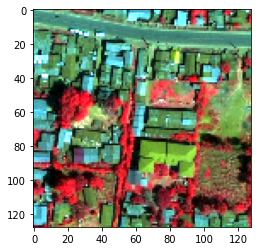

In [39]:
plt.imshow(Norma_Xpercentile(stack[0,:,:,]))

**Load the labels from SQLite and store it in numpy serie** 

In [40]:
# Load the labels stored in CSV into a pandas DataFrame
df_labels = pd.read_csv(os.path.join(label_path,"ranking_p3_20220202_NoClouds.csv"))
df_labels.head()

,photo_id,value
0,1.0,27.246599
1,2.0,25.581902
2,3.0,26.108904
3,4.0,26.940680
4,5.0,25.817791


In [41]:
# Normalise the labels in the range [0-1] (Min-Max normalisation)
df_labels['norm_value'] = (df_labels.loc[:,'value']-df_labels.loc[:,'value'].min())/(df_labels.loc[:,'value'].max()-df_labels.loc[:,'value'].min())
print(df_labels.head())
print('Min = %s'%round(df_labels.loc[:,'norm_value'].min(),5))
print('Max = %s'%round(df_labels.loc[:,'norm_value'].max(),5))

   photo_id      value  norm_value
0       1.0  27.246599    0.816679
1       2.0  25.581902    0.632830
2       3.0  26.108904    0.691032
3       4.0  26.940680    0.782893
4       5.0  25.817791    0.658882
Min = 0.0
Max = 1.0


In [42]:
# Extract the values of perception score and covert it to a 1-d array 
scores = df_labels.loc[:,'value'].values.astype(np.float16)
photo_id = df_labels.loc[:,'photo_id'].values.astype(np.int8)

In [43]:
# Now we need to reshape the 1-d array to a 2-d array 
scores = scores.reshape(scores.size,-1)
photo_id = photo_id.reshape(photo_id.size,-1)

# Check the shape and datatype of reference data
print(scores.shape)
print(scores.dtype)
print(scores)

(2005, 1)
float16
[[27.25]
 [25.58]
 [26.11]
 ...
 [25.14]
 [27.27]
 [26.22]]


In [44]:
# Before splitting the training and test dataset, let's check again the shape of x and y. 
print(stack.shape)
print(scores.shape)

(2005, 128, 128, 3)
(2005, 1)


In [45]:
# Check if labels and images ID match
set_images = set([int(os.path.splitext(x)[0].split("_")[-1]) for x in tile_list])
set_label = set(df_labels.loc[:,'photo_id'].values.tolist())
missing_label = list(sorted(set_images - set_label))
missing_image = list(sorted(set_label - set_images))
if missing_label or missing_image: 
    print('Label(s) ID missing:', missing_label)
    print('Image(s) ID missing:', missing_image)
else: 
    print('Labels and images ID match perfectly') 

Labels and images ID match perfectly


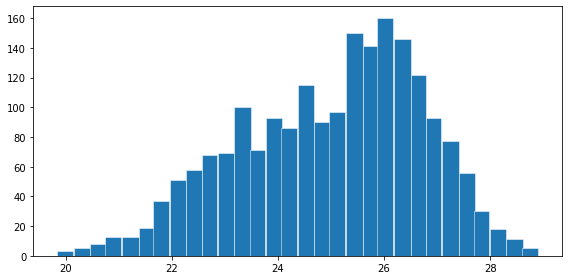

In [46]:
# print the distribution of target variables (y)
fig, axs = plt.subplots(1, 1,figsize =(8, 4), tight_layout = True)
axs.hist(scores, bins = 30, edgecolor='white', linewidth=0.5)
# Show plot
plt.show()

### 1.2 Splitting the input data

**Now, we split the input data into training+validation and test datasets.**

the proportion of training+validation and test follows the rule of thumb, 70% vs 30%.

In [47]:
# Split the inputs. Note that variable 'stack' is the X (imagery), and variable 'score' is the Y (labels).  
x_train, x_val, y_train, y_val = train_test_split(
    stack, scores, test_size = 0.1, random_state = 65) # specify the random state to ensure replicable output across multiple function calls.

# Check the shape of each sub-dataset 
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(1804, 128, 128, 3)
(1804, 1)
(201, 128, 128, 3)
(201, 1)


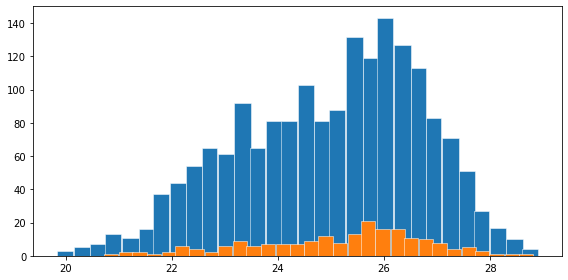

In [48]:
# print the distribution of target variables (y) in training and validation sets
fig, axs = plt.subplots(1, 1,figsize =(8, 4), tight_layout = True)
axs.hist(y_train, bins = 30, edgecolor='white', linewidth=0.5)
axs.hist(y_val, bins = 30, edgecolor='white', linewidth=0.5)
# Show plot
plt.show()

## 2. Deep CNN-based Regression Model 

In this part, we build a VGG-like model to predict the deprivation degree.

The CNN model has 4 convolution blocks and 3 fully connected layers. The details were presented below

### 2.1 Models Architecture Definition

#### **DenseNet121**

In [49]:
## DenseNet121 model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [50]:
# Input Shape
inputshape = (128, 128, 3)

# Define a different input layer
Input4bands = False
if not Input4bands: 
    input_tensor = Input(shape=inputshape)
else:
    input_tensor = Sequential()
    input_tensor.add(Conv2D(64, kernel_size=7, stride=2, padding=3, bias=False, name = 'fit_input', input_shape=Input(shape=(128, 128, 4)))) # Here 4 indicates 4-channel input
        
# Create the base pre-trained model
base_model = DenseNet121(input_tensor=input_tensor, input_shape=(128, 128, 3), weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a linear activation layer with 1 neuron for the regression
predictions = Dense(1, activation='linear')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
print(model.summary())

29097984/29084464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization

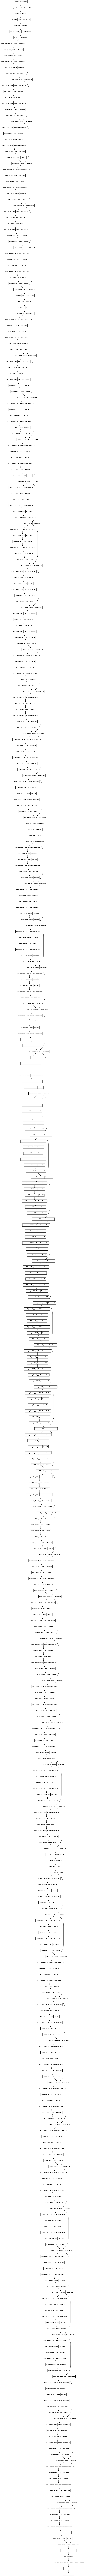

In [51]:
# Plot model architecture
plot_model(model, to_file=os.path.join(model_path,'DenseNet121_model.png'))

### 2.2 Data Augmentation Definition

In [52]:
# Set Image Data Generator
datagen = ImageDataGenerator(
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='reflect'
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


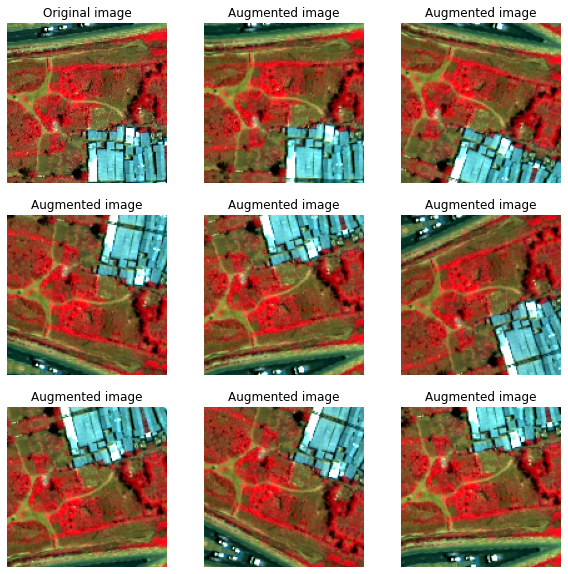

In [53]:
# Visualize the augmented data for an original image (in top left corner)
img_idx = 154
plt.rcParams["figure.facecolor"] = 'w'
pic = datagen.flow(np.expand_dims(x_train[img_idx], axis=0), batch_size =1, seed=3) 
plt.figure(figsize=(10, 10))
for i in range(9):
    if i==0:
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(Norma_Xpercentile(x_train[img_idx]))
        plt.axis("off")
        plt.title("Original image")
    else:
        ax = plt.subplot(3, 3, i + 1)
        batch = pic.next()
        plt.imshow(Norma_Xpercentile(batch[0]))
        plt.axis("off")
        plt.title("Augmented image")
plt.savefig(os.path.join(model_path,'Data_augmentation_A.png'), dpi=300, bbox_inches='tight')

### 2.3 Setting up the model

In [54]:
# Adam was applied as the optimizer for this model, with learning rate at 0.XXXX1 
#opt = Adam(learning_rate=1e-3, decay=1e-3/100)
opt = Adam(learning_rate=1e-2)

In [55]:
# Specify the R2 calculation formula to use as an assessment metric. 
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [56]:
# Using checkpoint callback fucntion to save the weights that yield the best result on validation dataset. 
checkpoint_filepath = os.path.join(output_path,'model','VGG_mae_best_performed_model.hdf5')
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

In [57]:
# Using 'Reduce LR on Plateau' function to let the model take smaller steps when the loss value hold on, and eventually maybe found a better optima.
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='auto', cooldown=0, min_lr=0)

In [58]:
# Using "Early stopping" function to stop the training when 
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=20) # probably needs to be more patient, but kaggle time is limited

### 2.4 Training the model

In [59]:
# Define a new instance of the model - Reinitialise model between diferent runs
model = DenseNet121()

33202176/33188688 [==============================] - 1s 0us/step


In [60]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional DenseNet121 layers
for layer in base_model.layers:
    layer.trainable = False

# Compilation of the model, loss function = MAE
model.compile(loss="mean_absolute_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 

# train the model on the new data for a few epochs
# Define hyperparameter
bsize = 10
nb_epochs = 15

# Train the model 
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=bsize, shuffle=False, seed=3),
    steps_per_epoch=int(len(x_train)/bsize),
    validation_data = (x_val,y_val),
    epochs = nb_epochs, 
    callbacks = [checkpoint, reduce, early]
)

Epoch 1/15
180/180 [==============================] - ETA: 0s - loss: 24.9787 - mean_absolute_error: 24.9780 - root_mean_squared_error: 25.0384 - coeff_determination: -280856.9688

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1525, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1514, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1507, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1471, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "densenet121" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 128, 128, 3)


Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.1945 - mean_absolute_error: 0.1945 - root_mean_squared_error: 0.2537 - coeff_determination: -3.3415
Epoch 00001: val_mean_absolute_error improved from inf to 0.44699, saving model to /home/partimap/PARTIMAP_processing/output/model/VGG_mae_best_performed_model.hdf5
28/28 [==============================] - 17s 512ms/step - loss: 0.1945 - mean_absolute_error: 0.1945 - root_mean_squared_error: 0.2537 - coeff_determination: -3.3415 - val_loss: 0.4470 - val_mean_absolute_error: 0.4470 - val_root_mean_squared_error: 0.4640 - val_coeff_determination: -14.0682 - lr: 0.0100
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.1336 - mean_absolute_error: 0.1336 - root_mean_squared_error: 0.1912 - coeff_determination: -1.4414
Epoch 00002: val_mean_absolute_error did not improve from 0.44699
28/28 [==============================] - 10s 349ms/step - loss: 0.1336 - mean_absolute_error: 0.1336 - root_mean_squared_

### 2.5 Visualizing the training history  
In this part, we plot the loss curve and metric curve

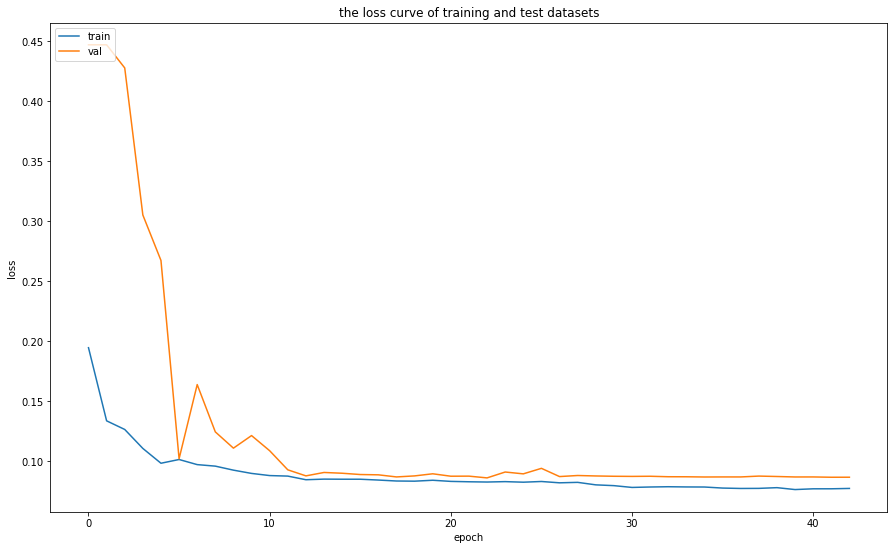

In [674]:
# plot model training history

fig = plt.subplots(figsize=(15, 9))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("the loss curve of training and test datasets")
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel("loss")
plt.xlabel("epoch")

plt.savefig(os.path.join(results_path,'mae_loss.png'), dpi = 300)
plt.show()

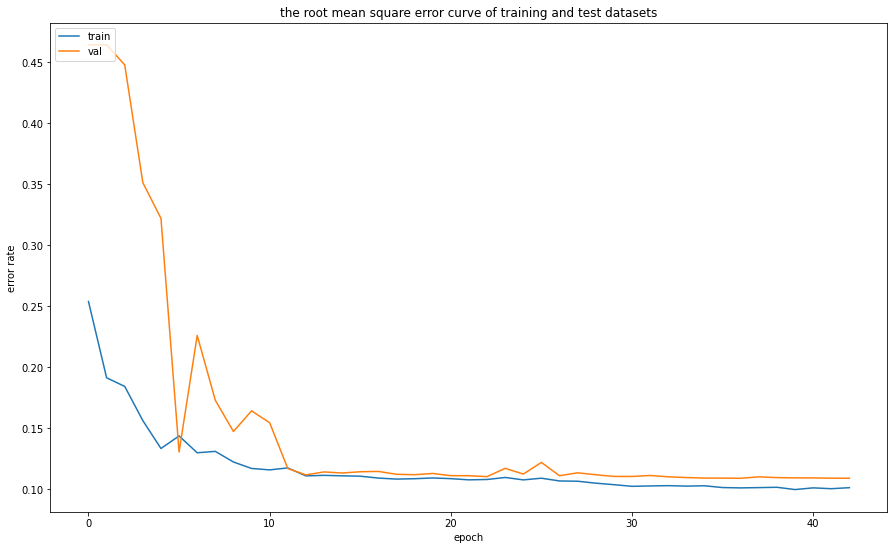

In [675]:
fig = plt.subplots(figsize=(15, 9))
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("the root mean square error curve of training and test datasets")
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel("error rate")
plt.xlabel("epoch")

plt.savefig(os.path.join(results_path,'mae_rmse.png'), dpi = 300)
plt.show()

## 3. Assessing the model performance on test datasets

### 3.1 Save and configure the model with best performance 

In this step, we will configure the model by reloading the weights of best performance through training, and apply it on both the training and validation datasets. The scatter plots will be created to evaluate the model prediction by comparing training and validation datasets, to see if there are over-/under-estimation or over-fitting etc. 

In [676]:
# Load best 
best_model = VGG_model()
#best_model = Simple_CNN()
best_model.load_weights(checkpoint_filepath)

### 3.2 Applying the model on validation datasets 

In [677]:
# run the model on the train and test datasets 
y_pred_val = best_model.predict(x_val) 
y_pred_train = best_model.predict(x_train)

In [678]:
# calculate the R2 Score and RMSE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

R2_train = r2_score(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train,squared=False) 
mae_train = mean_absolute_error(y_train, y_pred_train)

print("the R2 of training dataset is: %0.4f" %R2_train)
print("the RMSE of training dataset is: %0.4f" %rmse_train)
print("the MAE of training dataset is: %0.4f" %mae_train)

R2_val = r2_score(y_val,y_pred_val)
rmse_val = mean_squared_error(y_val, y_pred_val,squared=False) 
mae_val = mean_absolute_error(y_val, y_pred_val) 

print("the R2 of validation dataset is: %0.4f" %R2_val)
print("the RMSE of validation dataset is: %0.4f" %rmse_val)
print("the MAE of validation dataset is: %0.4f" %mae_val)

the R2 of training dataset is: 0.2424
the RMSE of training dataset is: 0.1083
the MAE of training dataset is: 0.0834
the R2 of validation dataset is: 0.2156
the RMSE of validation dataset is: 0.1103
the MAE of validation dataset is: 0.0860


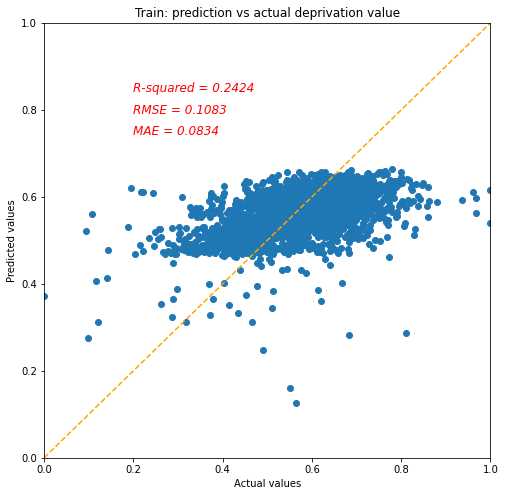

In [679]:
fig = plt.figure(figsize=(8,8)) 
ax=plt.subplot(1,1,1) 
ax.scatter(y_train, y_pred_train)  
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), c = 'orange', linestyle='--')
ax.set_title("Train: prediction vs actual deprivation value")
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted values")
ax.set_xlim([0,1.0])
ax.set_ylim([0,1.0])

ax.text(0.2, 0.85, "R-squared = %0.4f" % R2_train, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(0.2, 0.8, "RMSE = %0.4f" % rmse_train, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(0.2, 0.75, "MAE = %0.4f" % mae_train, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')

plt.savefig(os.path.join(results_path,'mae_train.png'), dpi = 300)
plt.show()

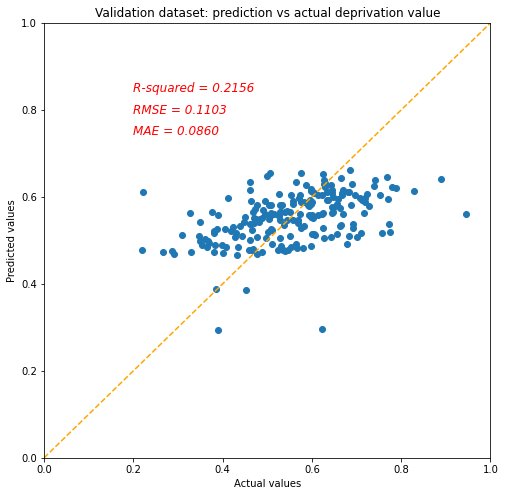

In [680]:
fig = plt.figure(figsize=(8,8)) 
ax=plt.subplot(1,1,1) 
ax.scatter(y_val, y_pred_val)  
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), c = 'orange', linestyle='--')
ax.set_title("Validation dataset: prediction vs actual deprivation value")
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted values")
ax.set_xlim([0,1.0])
ax.set_ylim([0,1.0])

ax.text(0.2, 0.85, "R-squared = %0.4f" % R2_val, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(0.2, 0.8, "RMSE = %0.4f" % rmse_val, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(0.2, 0.75, "MAE = %0.4f" % mae_val, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')

plt.savefig(os.path.join(results_path,'mae_val.png'), dpi = 300)
plt.show()